In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
import seaborn as sns

2024-03-16 21:19:51.998198: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 21:19:51.999399: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-16 21:19:52.017138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 21:19:52.017152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 21:19:52.017638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
import re
# Read in the images data
images = pd.read_csv('../datasets/images_dataset_clean2.csv')

# Read in the reports data 
reports = pd.read_csv('../datasets/report_dataset_w_fullstops_clean2.csv')

# Merge the images and reports data on the ID column
df = pd.merge(images, reports, on='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2612 non-null   int64  
 1   filename        2612 non-null   object 
 2   image_path      2612 non-null   object 
 3   report_file     2612 non-null   object 
 4   body_part       2612 non-null   object 
 5   content         2610 non-null   object 
 6   conclusion      2610 non-null   object 
 7   disease_status  2612 non-null   int64  
 8   disease_type    1472 non-null   object 
 9   location        0 non-null      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 204.2+ KB


In [3]:
df.head(5)

,id,filename,image_path,report_file,body_part,content,conclusion,disease_status,disease_type,location
0,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,tidak tampak kelainan radiologik.,0,NaN,NaN
1,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,tidak tampak kelainan radiologik.,0,NaN,NaN
2,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,tidak tampak kelainan radiologik.,0,NaN,NaN
3,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN
4,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abodemen_3_posisi,preperitoneal fat dan psoas line simetris. dis...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN


In [4]:
print(df.groupby('body_part').size())

body_part
BNO                        16
abodemen_3_posisi         256
ankle_bilateral             4
ankle_dextra               43
ankle_joint_bilateral       3
ankle_joint_dextra          2
ankle_sinistra             25
antebrachii                53
appendicogram              59
bahu_kanan_kiri            40
bahu_sinistra               2
calvaria                    2
cruris                     68
cubiti                     33
femur_bilateral             5
femur_dextra               38
femur_sinistra             28
genu                      289
hip_joint                  40
humerus                    14
humerus_biateral            6
humerus_dextra             16
humerus_sinistra           10
manus                      91
mastoid_bilateral           2
os_sacro_coccygeus         10
pedis_dextra               94
pedis_sinistra             51
pelvis                     61
schedel4                   16
sinus_paranasal            11
thorax_clean              407
vertebra_cervical         186


In [5]:
# remove body part containing less than 10 reports
body_parts_less_than_10 = ['ankle_bilateral', 'ankle_joint_bilateral', 'ankle_joint_dextra', 'bahu_dextra', 'bahu_sinistra', 'calvaria', 'clavicual_kanan', 'femur_bilateral', 'humerus', 'humerus_biateral', 'humerus_sinistra', 'humerus_dextra', 'mastoid_bilateral', 'os_sacro_coccygeus', 'schedel4', 'sinus_paranasal', 'wrist_joint_bilateral']
mask = ~df['body_part'].isin(body_parts_less_than_10)
df = df[mask]

In [8]:
# List of body parts to exclude
exclude_body_parts = ['abodemen_3_posisi', 'thorax_clean', 'vertebra_lumbosakral', 'vertebra_cervical', 'vertebra_thoracolumbal', 'genu']

# get all rows for normal and disease with shuffle
normal = df[(df['disease_status'] == 0) & (~df['body_part'].isin(exclude_body_parts))].sample(frac=1)
disease = df[(df['disease_status'] == 1) & (~df['body_part'].isin(exclude_body_parts))].sample(frac=1)

normal_duplicate = normal.sample(2000, replace=True)
disease_duplicate = disease.sample(1500, replace=True)

df = pd.concat([df, normal_duplicate])
df = pd.concat([df, disease_duplicate])

print(df.groupby('body_part').size())

body_part
BNO                       151
abodemen_3_posisi         256
ankle_dextra              419
ankle_sinistra            209
antebrachii               507
appendicogram             643
bahu_kanan_kiri           397
cruris                    670
cubiti                    367
femur_dextra              396
femur_sinistra            278
genu                      289
hip_joint                 384
manus                     897
pedis_dextra              915
pedis_sinistra            505
pelvis                    560
thorax_clean              407
vertebra_cervical         186
vertebra_lumbosakral      471
vertebra_thoracolumbal    100
wrist_joint_dextra        255
wrist_joint_sinistra      236
dtype: int64


disease_status
0    5100
1    4398
Name: count, dtype: int64


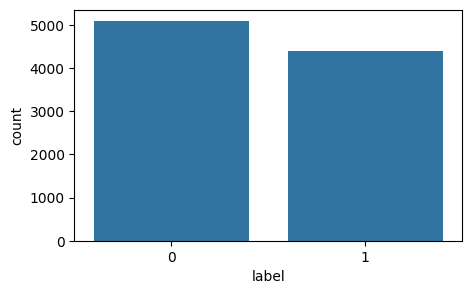

In [44]:
print(df['disease_status'].value_counts())

plt.figure(figsize=(5, 3)) 
sns.countplot(x='disease_status', data=df)
plt.xlabel('label')
plt.ylabel('count')

plt.show()

In [9]:
print(f"Number of classes in body part: {df['body_part'].nunique()}")

Number of classes in body part: 23


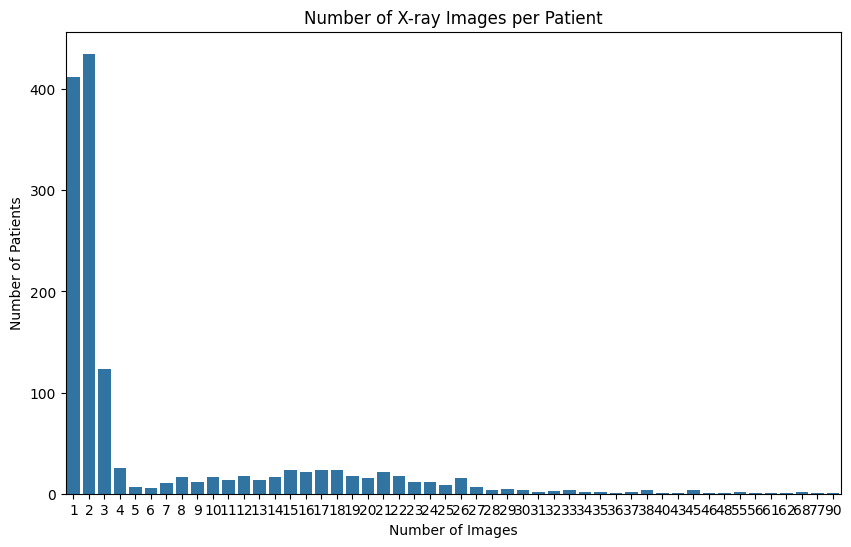

In [10]:
# Count the number of images per patient
images_per_patient = df['id'].value_counts()

# Convert from Series to Dataframe
images_per_patient_df = images_per_patient.reset_index()

# Specify columns
images_per_patient_df.columns = ['patient_id', 'image_count']

# Plot the distribution of images per patient using countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='image_count', data=images_per_patient_df)
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.title('Number of X-ray Images per Patient')
plt.show()

In [11]:
df.drop(columns=["filename", "report_file", "content", "conclusion", "disease_type", "location"], inplace=True)
df = df.rename(columns={'id': 'patient_id'})

df.head(5)

,patient_id,image_path,body_part,disease_status
0,1,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi,0
1,1,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi,0
2,1,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi,0
3,2,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi,1
4,2,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi,1


In [14]:
def show_image_normal(loc):
    img = cv2.imread(df['image_path'].loc[loc])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.imshow(img)
    plt.title(df['image_path'].loc[loc], fontsize=9)
    plt.show()
    print(f"Image path: {df['image_path'].loc[loc]}")

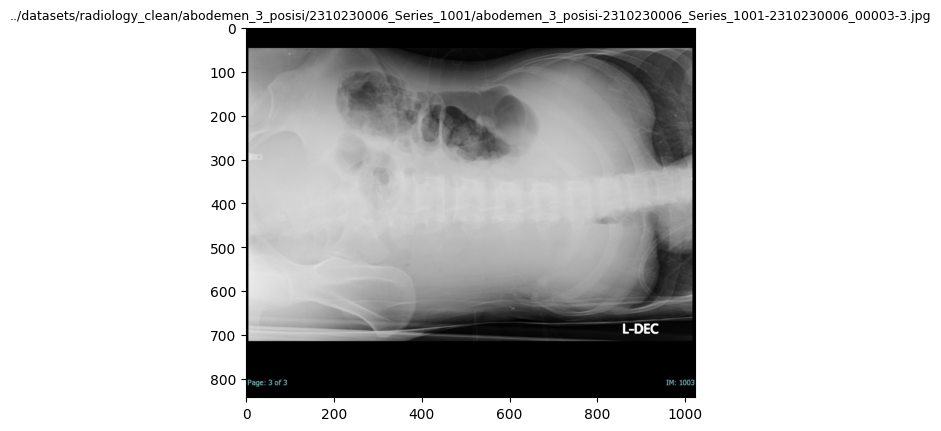

Image path: ../datasets/radiology_clean/abodemen_3_posisi/2310230006_Series_1001/abodemen_3_posisi-2310230006_Series_1001-2310230006_00003-3.jpg


In [15]:
show_image_normal(11)

In [16]:
from keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    return preprocess_input(img_array)

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
   
    return image, label

In [20]:
def show_image(data, loc, target_size=(224, 224)):
    img_path = data['image_path'].loc[loc]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_preprocessed = preprocess_image(img_path)
    preprocessed_img_tensor = tf.convert_to_tensor(img_preprocessed, dtype=tf.float32)
    preprocessed_img_tensor = tf.expand_dims(preprocessed_img_tensor, axis=0)  # Add batch dimension

    augmented_img, _ = augment(preprocessed_img_tensor[0], 0)

    # Check if the image is horizontal (width > height)
    if img.shape[1] > img.shape[0]:
        # Rotate the image by 90 degrees clockwise to make it vertical
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

    # Resize the image
    img = cv2.resize(img, target_size)
    
    # Display the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Display the pre-processed image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 2)
    plt.imshow(img_preprocessed)
    plt.title('Preprocessed Image')
    plt.axis('off')

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 3)
    plt.imshow(augmented_img.numpy())
    plt.title('Augmented Image')
    plt.axis('off')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


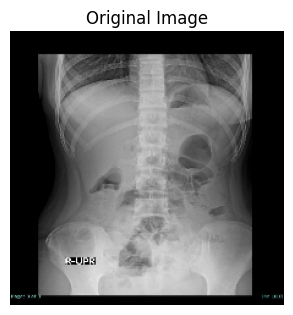

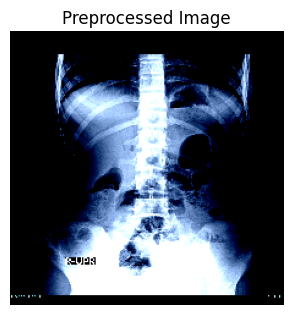

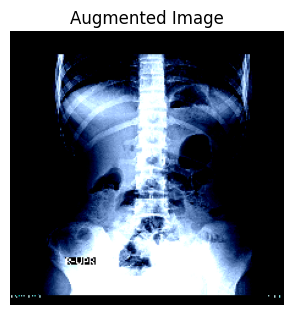

In [21]:
show_image(df, loc=30)

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import math

BUFFER_SIZE = 2000
BATCH_SIZE = 64

label_encoder = LabelEncoder()

def preprocess_data(data):
    x = []
    y_binary = []
    y_multiclass = []

    for _, row in df.iterrows():
        img_path = row['image_path']
        disease_label = row['disease_status']
        bodypart_label = row['body_part']
        
        img = preprocess_image(img_path)

        x.append(img)
        y_binary.append(disease_label)
        y_multiclass.append(bodypart_label)
        
    x = np.array(x)
    y_binary = np.array(y_binary)
    y_multiclass = label_encoder.fit_transform(y_multiclass)  # convert labels to integers
    num_classes = len(label_encoder.classes_)  # Get the number of classes
    y_multiclass = to_categorical(y_multiclass, num_classes=num_classes)  # one-hot encode labels
    return x, y_binary, y_multiclass

X, y_binary, y_multiclass = preprocess_data(df)

# Split the preprocessed data 
x_train, x_test, y_binary_train, y_binary_test, y_multiclass_train, y_multiclass_test = train_test_split(X, y_binary, y_multiclass, test_size=0.2, random_state=42)

# Convert labels to dictionaries
train_labels = {'binary_output': y_binary_train, 'multiclass_output': y_multiclass_train}
test_labels = {'binary_output': y_binary_test, 'multiclass_output': y_multiclass_test}

# Convert the training and test data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_dataset, test_dataset)
print("\n")

# Count the number of images for each label in the binary task for the train data
unique_binary, counts_binary = np.unique(y_binary_train, return_counts=True)
train_binary_label_counts = dict(zip(unique_binary, counts_binary))
print("Train data binary label counts:", train_binary_label_counts)

# Count the number of images for each label in the binary task for the test data
unique_binary, counts_binary = np.unique(y_binary_test, return_counts=True)
test_binary_label_counts = dict(zip(unique_binary, counts_binary))
print("Test data binary label counts:", test_binary_label_counts)

print("\n")

# Count the number of images for each label in the multiclass task for the train data
# argmax(axis=1) to convert one-hot encoded labels to their original integer labels
unique_multiclass, counts_multiclass = np.unique(y_multiclass_train.argmax(axis=1), return_counts=True)
train_multiclass_label_counts = dict(zip(unique_multiclass, counts_multiclass))
print("Train data multiclass label counts:", train_multiclass_label_counts)

# Count the number of images for each label in the multiclass task for the test data
unique_multiclass, counts_multiclass = np.unique(y_multiclass_test.argmax(axis=1), return_counts=True)
test_multiclass_label_counts = dict(zip(unique_multiclass, counts_multiclass))
print("Test data multiclass label counts:", test_multiclass_label_counts)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), {'binary_output': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'multiclass_output': TensorSpec(shape=(None, 23), dtype=tf.float32, name=None)})> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), {'binary_output': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'multiclass_output': TensorSpec(shape=(None, 23), dtype=tf.float32, name=None)})>


Train data binary label counts: {0: 4077, 1: 3521}
Test data binary label counts: {0: 1023, 1: 877}


Train data multiclass label counts: {0: 119, 1: 197, 2: 328, 3: 157, 4: 413, 5: 513, 6: 319, 7: 541, 8: 300, 9: 319, 10: 215, 11: 231, 12: 313, 13: 706, 14: 733, 15: 406, 16: 460, 17: 314, 18: 152, 19: 380, 20: 86, 21: 196, 22: 200}
Test data multiclass label counts: {0: 32, 1: 59, 2: 91, 3: 52, 4: 94, 5: 130, 6: 78, 7: 129, 8: 67, 9: 77, 10: 63, 11: 58, 12: 71, 13: 191, 14: 182, 15: 9

In [23]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras import backend as K
import numpy as np
import os
from tensorflow.keras.applications.vgg19 import VGG19


base_model =VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3)
)

# freeze all the layers
for layer in base_model.layers:
    layer.trainable = False
 
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
input_tensor = Input(shape=(224, 224, 3), name="input_layer")
x = base_model(input_tensor, training=False)  # training=False to avoid updating batch norm statistics
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x) 

# binary classification 
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)

# multiclass classification
multiclass_output = Dense(23, activation='softmax', name='multiclass_output')(x)

# model with two output layers: binary & multiclass classification
model = Model(inputs=input_tensor, outputs=[binary_output, multiclass_output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg19 (Functional)          (None, 7, 7, 512)            2002438   ['input_layer[0][0]']         
                                                          4                                       
                                                                                                  
 global_average_pooling2d (  (None, 512)                  0         ['vgg19[0][0]']               
 GlobalAveragePooling2D)                                                                          
                                                                                              

In [26]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam',
              loss={'binary_output': 'binary_crossentropy', 'multiclass_output': 'categorical_crossentropy'},
              metrics={'binary_output': 'accuracy', 'multiclass_output': 'accuracy'})

In [27]:
early_stop = EarlyStopping(monitor = 'val_loss', patience= 16)

In [28]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
    callbacks=[early_stop]
)

Epoch 1/30
119/119 [==============================] - 341s 3s/step - loss: 2.3173 - binary_output_loss: 0.6472 - multiclass_output_loss: 1.6702 - binary_output_accuracy: 0.6290 - multiclass_output_accuracy: 0.5453 - val_loss: 1.4774 - val_binary_output_loss: 0.5846 - val_multiclass_output_loss: 0.8928 - val_binary_output_accuracy: 0.6837 - val_multiclass_output_accuracy: 0.7647
Epoch 2/30
119/119 [==============================] - 349s 3s/step - loss: 1.3998 - binary_output_loss: 0.6029 - multiclass_output_loss: 0.7969 - binary_output_accuracy: 0.6674 - multiclass_output_accuracy: 0.7476 - val_loss: 1.1563 - val_binary_output_loss: 0.5593 - val_multiclass_output_loss: 0.5970 - val_binary_output_accuracy: 0.7189 - val_multiclass_output_accuracy: 0.8263
Epoch 3/30
119/119 [==============================] - 349s 3s/step - loss: 1.1735 - binary_output_loss: 0.5808 - multiclass_output_loss: 0.5928 - binary_output_accuracy: 0.6911 - multiclass_output_accuracy: 0.8049 - val_loss: 1.0329 - val

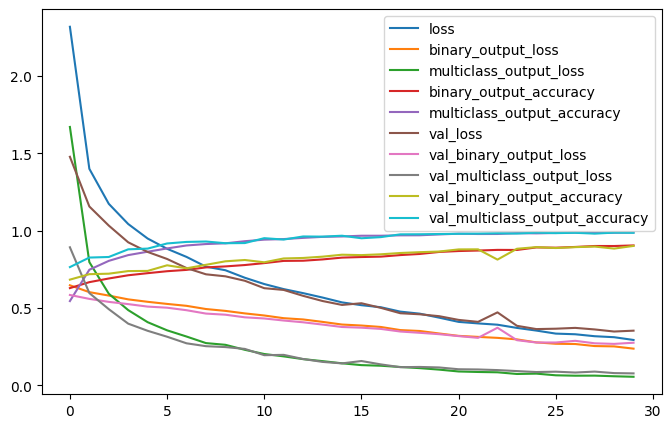

In [30]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [29]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# predict on the test dataset
predictions = model.predict(test_dataset)
binary_predictions, multiclass_predictions = predictions

# binary classification
binary_predicted_labels = (binary_predictions > 0.5).astype(int).flatten()

binary_true_labels = y_binary_test  

# binary classification accuracy score
binary_accuracy = accuracy_score(binary_true_labels, binary_predicted_labels)
print(f'Test accuracy for binary task: {binary_accuracy:.2f}')

# binary classification ROC-AUC score
binary_auc = roc_auc_score(binary_true_labels, binary_predictions)
print(f'Test ROC-AUC for binary task: {binary_auc:.2f}')

# multiclass classification
multiclass_predicted_labels = np.argmax(multiclass_predictions, axis=1)

# converts one-hot encoded into integer class labels
multiclass_true_labels = np.argmax(y_multiclass_test, axis=1)  

# multiclass classification accuracy score
multiclass_accuracy = accuracy_score(multiclass_true_labels, multiclass_predicted_labels)
print(f'Test accuracy for multiclass task: {multiclass_accuracy:.2f}')

# multiclass classification F1 score
multiclass_f1_score = f1_score(multiclass_true_labels, multiclass_predicted_labels, average='weighted')
print(f'Test F1 score for multiclass task (weighted average): {multiclass_f1_score:.2f}')

30/30 [==============================] - 70s 2s/step
Test accuracy for binary task: 0.90
Test ROC-AUC for binary task: 0.96
Test accuracy for multiclass task: 0.99
Test F1 score for multiclass task (weighted average): 0.99


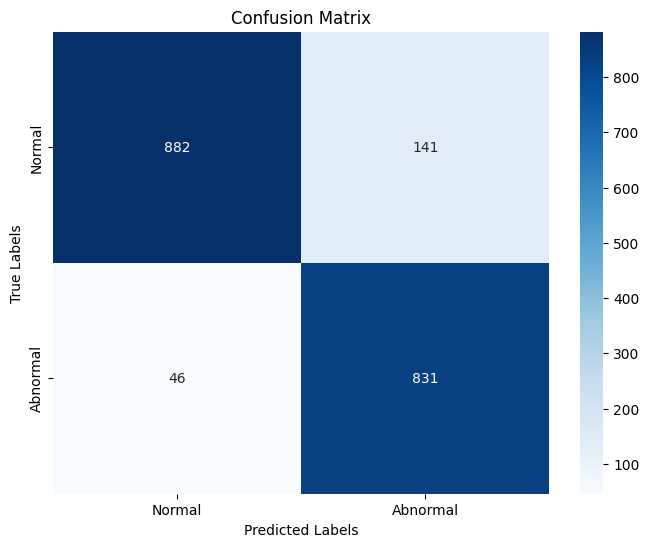

In [31]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for binary classification
conf_matrix = confusion_matrix(binary_true_labels, binary_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
import random

def predict_binary(test_dataset, model):
    # convert the test dataset to a list of batches
    batches = list(test_dataset.unbatch().map(lambda x, y: (x, y['binary_output'])).batch(1).as_numpy_iterator())

    # randomly select a batch (one image and its label)
    random_index = random.randint(0, len(batches) - 1)
    img, true_binary_label = batches[random_index]

    # add batch dimension 
    img_batch = np.expand_dims(img, axis=0)
    prediction = model.predict(img_batch)
    # prediction[0]: predicted probabilities for binary classification
    # if prediction > 0.5: True; else False
    predicted_binary_label = (prediction[0] > 0.5).astype(int).flatten()[0]

    print(f"Predicted binary label: {predicted_binary_label}, True binary label: {true_binary_label}")

def predict_multiclass(test_dataset, model, label_encoder= None):
    # convert the test dataset to a list of batches
    batches = list(test_dataset.unbatch().map(lambda x, y: (x, y['multiclass_output'])).batch(1).as_numpy_iterator())

    # randomly select a batch (one image and its label)
    random_index = random.randint(0, len(batches) - 1)
    img, true_multiclass_label = batches[random_index]

    img_batch = np.expand_dims(img, axis=0)
    prediction = model.predict(img_batch)
    # find max value in array of prediction probabilities
    predicted_multiclass_label = np.argmax(prediction[1][0])

    # convert integer labels to class names
    predicted_class_name = label_encoder.inverse_transform([predicted_multiclass_label])[0]
    true_class_name = label_encoder.inverse_transform([np.argmax(true_multiclass_label)])[0]

    print(f"Predicted class: {predicted_class_name}, True class: {true_class_name}")

    print(f"Predicted multiclass label: {predicted_multiclass_label}, True multiclass label: {np.argmax(true_multiclass_label)}")

In [40]:
predict_binary(test_dataset, model)

1/1 [==============================] - 0s 56ms/step
Predicted binary label: 0, True binary label: [0]


In [42]:
predict_multiclass(test_dataset, model, label_encoder)

1/1 [==============================] - 0s 54ms/step
Predicted class: pedis_dextra, True class: pedis_dextra
Predicted multiclass label: 14, True multiclass label: 14


In [43]:
model.save('multitask_model.h5')

/home/radiology/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
